In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [3]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/gender/Training'
val_data_dir = '/content/drive/My Drive/Colab Notebooks/gender/Validation'

In [4]:
paths_dict = {
    'female': [],
    'male': [],
    'stranger': []
}

In [5]:
# print(paths_dict.keys())

for key in paths_dict.keys():
    # print(key)
    # print(os.walk(os.path.join(train_data_dir, key)))
    for dirname, _, filenames in os.walk(os.path.join(train_data_dir, key)):
        # print('msg : ', dirname, filenames)
        for filename in filenames:
            # print('filename: ', filename)
            # print(os.path.join(dirname, filename))
            
            data = paths_dict[key].append(os.path.join(dirname, filename))
            # print('paths_dict[key]: ', data)

In [6]:
groups = [key + '\n' + str(len(paths_dict[key])) 
          for key in paths_dict.keys()]
count_data = [len(paths_dict[key])
          for key in paths_dict.keys()]

colors = ['b', 'r', 'g']

Visualization of the amount of train data in classes

<BarContainer object of 3 artists>

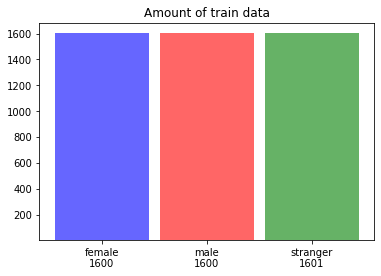

In [7]:
plt.title('Amount of train data')

width = len(count_data) * 0.3
plt.bar(groups, count_data, width=width, color=colors, alpha=0.6, bottom=2, linewidth=2)

Creation of directories for generators

In [8]:
train_dir = '/content/drive/My Drive/Colab Notebooks/vgg16/train_dir'
test_dir = '/content/drive/My Drive/Colab Notebooks/vgg16/test_dir'

In [9]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    
    for key in paths_dict.keys():
        os.makedirs(os.path.join(dir_name, key))

In [10]:
create_directory(train_dir)
create_directory(test_dir)

In [11]:
def copy_images(start_index, end_index, paths, dest_dir):
    for i in range(start_index, end_index):
        dest_path = os.path.join(dest_dir, paths[i].split('/')[7])
        shutil.copy2(paths[i], dest_path)

In [12]:
# Part of the test data set
test_data_proportion = 0.2

In [13]:
for key in paths_dict.keys():
    test_index = len(paths_dict[key]) - int(len(paths_dict[key]) * test_data_proportion)
    
    copy_images(0, test_index, paths_dict[key], train_dir)
    copy_images(test_index, len(paths_dict[key]), paths_dict[key], test_dir)

The creation of generators

In [14]:
target_size = (224, 224)
batch_size = 60
mode = 'categorical'

In [15]:
datagen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [16]:
train_gen = datagen.flow_from_directory(train_dir,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode=mode)

Found 3841 images belonging to 3 classes.


In [17]:
val_gen = datagen.flow_from_directory(val_data_dir,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode=mode)

Found 1200 images belonging to 3 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [19]:
test_gen = test_datagen.flow_from_directory(test_dir,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode=mode)

Found 960 images belonging to 3 classes.


In [20]:
# indexes of labels
train_gen.class_indices

{'female': 0, 'male': 1, 'stranger': 2}

In [21]:
test_gen.class_indices

{'female': 0, 'male': 1, 'stranger': 2}

In [22]:
len_train_data = len(train_gen.filenames)
len_test_data = len(test_gen.filenames)
len_val_data = len(val_gen.filenames)
print(len_train_data,len_test_data, len_val_data)

3841 960 1200


Amount of data in generators

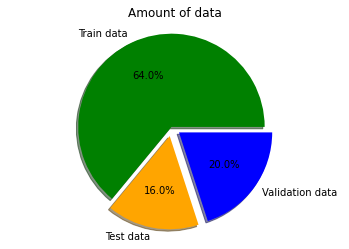

In [23]:
labels = ['Train data', 'Test data', 'Validation data']
values = [len_train_data, len_test_data, len_val_data]
colors = ['green','orange','blue']
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, explode=(0, 0.1, 0.1))
plt.axis('equal')
plt.title('Amount of data')
plt.show()

# Model and callbacks

In [24]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [25]:
vgg.trainable = False

The creation of callback for model without tuning

In [26]:
model_without_tuning = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_without_tuning,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)

In [27]:
#from tensorflow.keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='auto', verbose=2, patience=5)

The creation of model

In [28]:
model = Sequential()
model.add(vgg)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

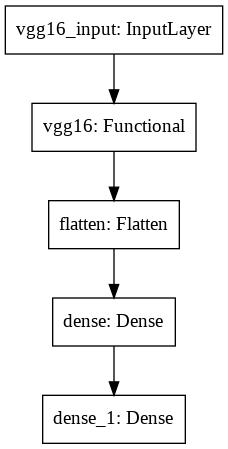

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.jpg')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
model.compile(loss='categorical_crossentropy',
             metrics=['accuracy'],
             optimizer='adam')

In [32]:
history_without_tuning = model.fit_generator(train_gen,
                   steps_per_epoch=len_train_data // batch_size,
                   epochs=10,
                   validation_data=val_gen,
                   validation_steps=len_val_data // batch_size,
                   verbose=1,
                   callbacks=[checkpoint_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
43/64 [===================>..........] - ETA: 16s - loss: 1.4418 - accuracy: 0.6747

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


64/64 [==============================] - ETA: 0s - loss: 1.0901 - accuracy: 0.7281
Epoch 00001: val_accuracy improved from -inf to 0.89417, saving model to best_model.h5
64/64 [==============================] - 367s 6s/step - loss: 1.0901 - accuracy: 0.7281 - val_loss: 0.2736 - val_accuracy: 0.8942
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.8995
Epoch 00002: val_accuracy improved from 0.89417 to 0.90167, saving model to best_model.h5
64/64 [==============================] - 79s 1s/step - loss: 0.2399 - accuracy: 0.8995 - val_loss: 0.2444 - val_accuracy: 0.9017
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9154
Epoch 00003: val_accuracy improved from 0.90167 to 0.90833, saving model to best_model.h5
64/64 [==============================] - 73s 1s/step - loss: 0.2090 - accuracy: 0.9154 - val_loss: 0.2172 - val_accuracy: 0.9083
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.2822

In [33]:
model.load_weights(model_without_tuning)

In [34]:
results_without_tuning = model.evaluate_generator(test_gen,
                                   len_test_data // batch_size,
                                   verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
16/16 [==============================] - 3s 208ms/step - loss: 0.1240 - accuracy: 0.9521


Fine tuning of the model

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


Defrosting layers

In [36]:
model.layers[0].trainable = True

In [37]:
for layer in model.layers[0].layers:
    if 'block3' not in layer.name:
        layer.trainable = False

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 21,138,243
Trainable params: 7,898,883
Non-trainable params: 13,239,360
_________________________________________________________________


In [39]:
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Callback for model with tuning

In [40]:
model_with_tuning = 'best_tune_model.h5'
checkpoint_callback = ModelCheckpoint(model_with_tuning,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)

In [41]:
history_with_tuning = model.fit_generator(train_gen,
                   steps_per_epoch=len_train_data // batch_size,
                   epochs=10,
                   validation_data=val_gen,
                   validation_steps=len_val_data // batch_size,
                   verbose=1,
                   callbacks=[checkpoint_callback])

Epoch 1/10
55/64 [========================>.....] - ETA: 7s - loss: 0.1324 - accuracy: 0.9488

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


64/64 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9484
Epoch 00001: val_accuracy improved from -inf to 0.93417, saving model to best_tune_model.h5
64/64 [==============================] - 69s 1s/step - loss: 0.1310 - accuracy: 0.9484 - val_loss: 0.1642 - val_accuracy: 0.9342
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9529
Epoch 00002: val_accuracy improved from 0.93417 to 0.94667, saving model to best_tune_model.h5
64/64 [==============================] - 70s 1s/step - loss: 0.1205 - accuracy: 0.9529 - val_loss: 0.1387 - val_accuracy: 0.9467
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9545
Epoch 00003: val_accuracy did not improve from 0.94667
64/64 [==============================] - 69s 1s/step - loss: 0.1228 - accuracy: 0.9545 - val_loss: 0.1351 - val_accuracy: 0.9467
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9579
Epoch 

In [42]:
model.load_weights(model_with_tuning)

In [43]:
results_with_tuning = model.evaluate_generator(test_gen,
                                   len_test_data // batch_size,
                                   verbose=1)

16/16 [==============================] - 4s 220ms/step - loss: 0.0986 - accuracy: 0.9604


# Data visualization

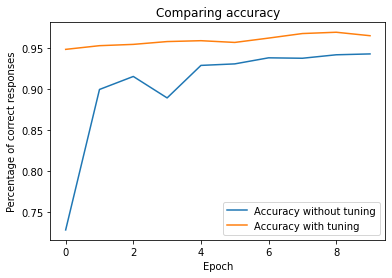

In [44]:
plt.plot(history_without_tuning.history['accuracy'], 
         label='Accuracy without tuning')
plt.plot(history_with_tuning.history['accuracy'],
         label='Accuracy with tuning')
plt.xlabel('Epoch')
plt.ylabel('Percentage of correct responses')
plt.title('Comparing accuracy')
plt.legend()
plt.show()

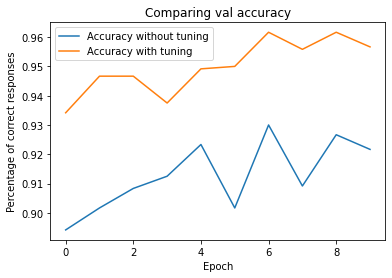

In [45]:
plt.plot(history_without_tuning.history['val_accuracy'], 
         label='Accuracy without tuning')
plt.plot(history_with_tuning.history['val_accuracy'],
         label='Accuracy with tuning')
plt.xlabel('Epoch')
plt.ylabel('Percentage of correct responses')
plt.title('Comparing val accuracy')
plt.legend()
plt.show()

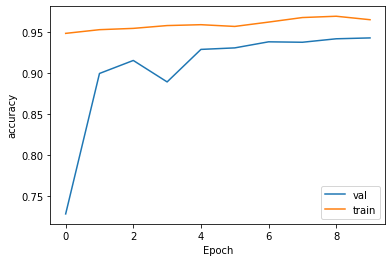

In [86]:
plt.plot(history_without_tuning.history['accuracy'], 
         label='val')
plt.plot(history_with_tuning.history['accuracy'],
         label='train')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

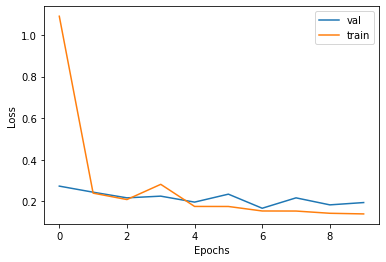

In [87]:
val_loss = history_without_tuning.history['val_loss']
loss = history_without_tuning.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['val','train'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

In [46]:
counts = [results_without_tuning[1], results_with_tuning[1]]
groups = ['Without tuning\n' + str(int(counts[0] * 10000) / 100) + '%',
          'With tuning\n' + str(int(counts[1] * 10000) / 100) + '%']

colors = ['r', 'b']

<BarContainer object of 2 artists>

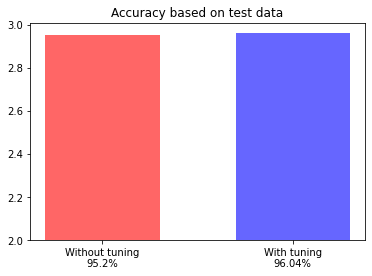

In [47]:
plt.title('Accuracy based on test data')

width = len(counts) * 0.3
plt.bar(groups, counts, width=width, color=colors, alpha=0.6, bottom=2, linewidth=2)

In [48]:
counts = [results_without_tuning[0], results_with_tuning[0]]
groups = ['Without tuning\n' + str(int(counts[0] * 10000) / 100) + '%',
          'With tuning\n' + str(int(counts[1] * 10000) / 100) + '%']

colors = ['r', 'b']

<BarContainer object of 2 artists>

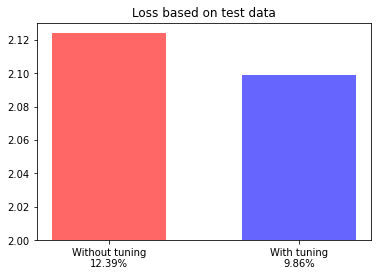

In [49]:
plt.title('Loss based on test data')

width = len(counts) * 0.3
plt.bar(groups, counts, width=width, color=colors, alpha=0.6, bottom=2, linewidth=2)

# Visualization of features defined by the tuned model

In [50]:
# paths_dict

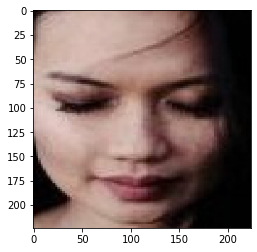

In [51]:
img = image.load_img(paths_dict['female'][0], target_size=(224, 224))
plt.imshow(img)

In [52]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

In [53]:
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Let's see what features the model highlights after the first block of layers

In [54]:
activation_model = Model(inputs=model.layers[0].layers[0].input, outputs=model.layers[0].layers[3].output)

In [55]:
activation = activation_model.predict(img_array)

In [56]:
images_per_row = 16
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

In [57]:
display_grid = np.zeros((n_cols * size, images_per_row * size))

In [58]:
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

The most prominent features of the model are highlighted in yellow.

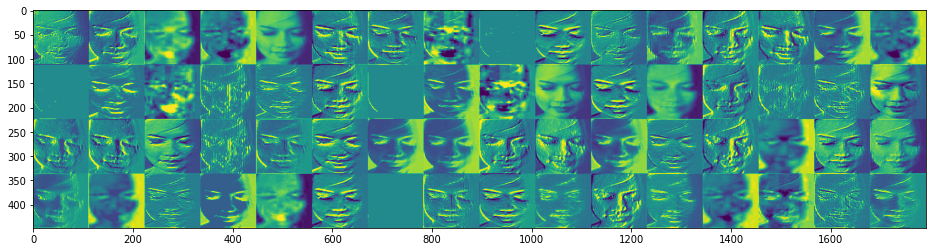

In [59]:
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

And let's see what features the model highlights after the third block of layers.

In [60]:
activation_model = Model(inputs=model.layers[0].layers[0].input, outputs=model.layers[0].layers[6].output)

In [61]:
activation = activation_model.predict(img_array)

In [62]:
images_per_row = 16
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

In [63]:
display_grid = np.zeros((n_cols * size, images_per_row * size))

In [64]:
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

You can see that in the third block, the model highlights more significant features of the face for classification.

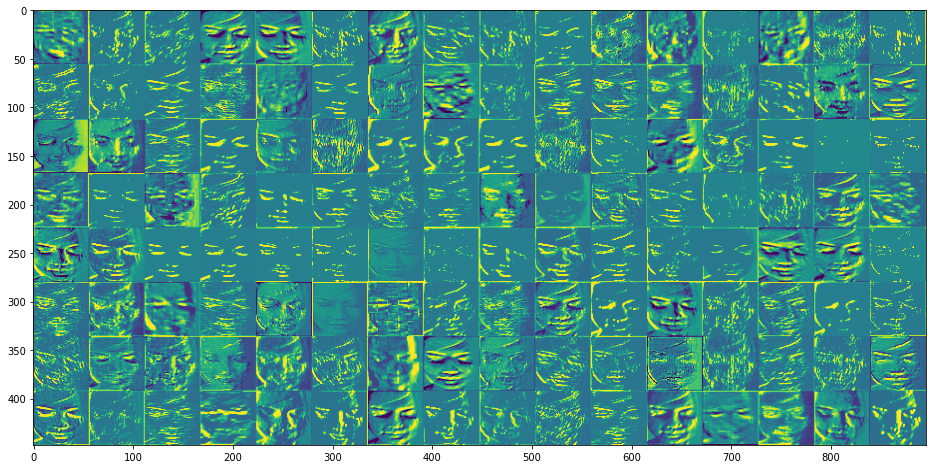

In [65]:
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [66]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model.h5')

In [67]:
pred = model.predict_generator(test_gen)
print(pred.shape)

Instructions for updating:
Please use Model.predict, which supports generators.
(960, 3)


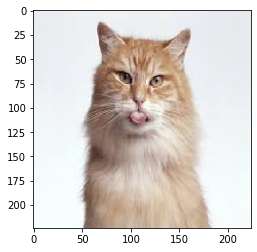

In [68]:
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/gender/Training/stranger/with_mask_2689.jpeg', target_size=(224, 224))
plt.imshow(img)

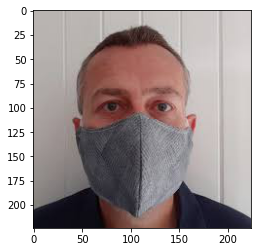

In [71]:
img_idx = 500
img = image.load_img(paths_dict['stranger'][img_idx], target_size=(224, 224))
plt.imshow(img)

# print(paths_dict['stranger'][img_idx].)

In [72]:
print(pred[0][img_idx])
print(pred[1][img_idx])
print(pred[2][img_idx])

IndexError: ignored

In [73]:
pred = pred.reshape(3, pred.shape[0])
predicted_class_indices= np.round_(pred)
labels = (test_gen.class_indices)
print(predicted_class_indices)

[[0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]]


In [74]:
np.unique(predicted_class_indices)

array([0., 1.], dtype=float32)

In [75]:
pred.shape[1]

960

In [76]:
pred.shape

# 3840 960 1200 train test val

(3, 960)

In [77]:
val_dir_female = '/content/drive/MyDrive/Colab Notebooks/vgg16/test_dir/female'
val_dir_male = '/content/drive/MyDrive/Colab Notebooks/vgg16/test_dir/male'
val_dir_stranger = '/content/drive/MyDrive/Colab Notebooks/vgg16/test_dir/stranger'

In [80]:
true_labels = []
perdict_labels = predicted_class_indices[0]

for i in range(len(glob.glob(val_dir_female +'/*'))):
    true_labels.append(0)
for i in range(len(glob.glob(val_dir_male +'/*'))):
    true_labels.append(1)
for i in range(len(glob.glob(val_dir_stranger +'/*'))):
    true_labels.append(2)

cm :  [[213 107   0]
 [213 107   0]
 [214 106   0]]


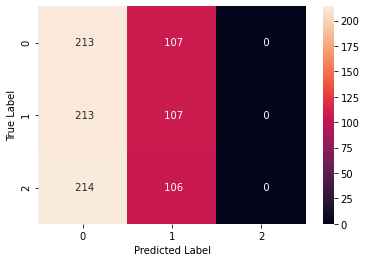

<Figure size 432x288 with 0 Axes>

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, perdict_labels)
print('cm : ' , cm)
sns.heatmap(cm, fmt='4',annot=True).set(ylabel="True Label", xlabel="Predicted Label")
plt.show()
plt.savefig('confusion_matrix.jpg')

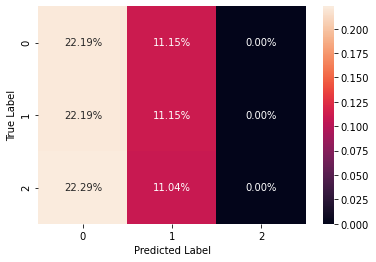

<Figure size 432x288 with 0 Axes>

In [82]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%').set(ylabel="True Label", xlabel="Predicted Label")
#print(sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%').set(ylabel="True Label", xlabel="Predicted Label"))
plt.show()
plt.savefig('confusion_matrix_percentage.jpg')

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


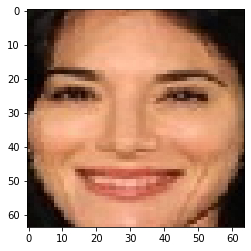

True Label female - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


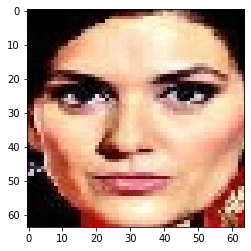

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


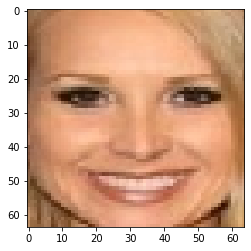

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


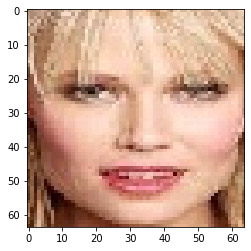

True Label female - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


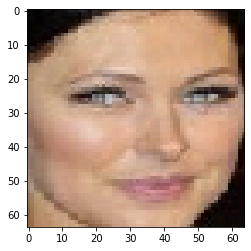

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


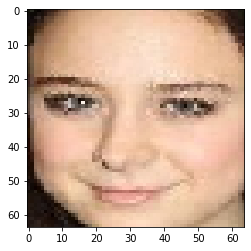

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


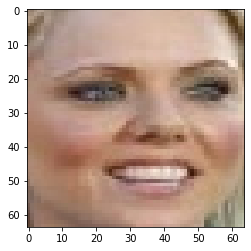

True Label female - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


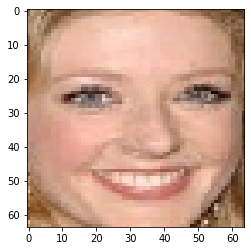

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


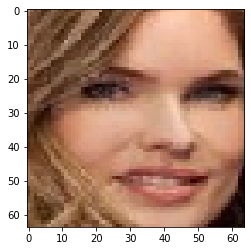

True Label female - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


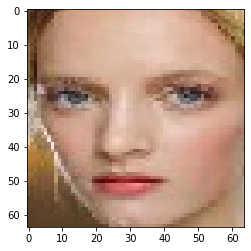

In [79]:
import glob
paths = glob.glob(val_dir_female +'/*')

for i in range(0,10):
    test_image = image.load_img(paths[i], target_size = (64, 64))
    plt.imshow(test_image)
    if predicted_class_indices[0][i] == 0:
        pred_label = 'female'
    elif predicted_class_indices[0][i] == 1:
        pred_label = 'male'
    else:
        pred_label = 'stranger'
    
    print('True Label female - Perdict Label : {}'.format(pred_label))
    labels = (train_gen.class_indices)
    print(labels)
    plt.show()

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


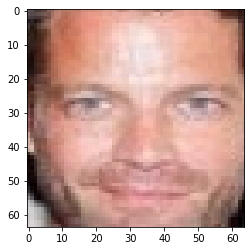

True Label male - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


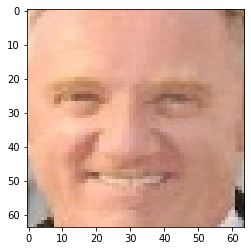

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


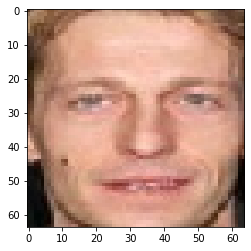

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


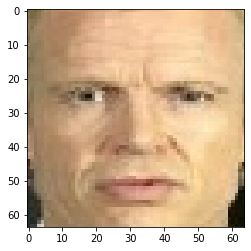

True Label male - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


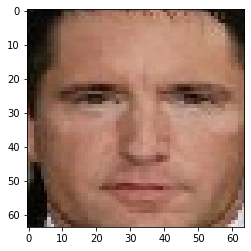

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


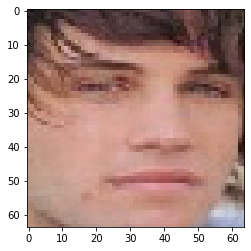

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


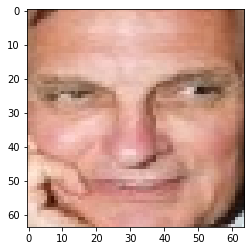

True Label male - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


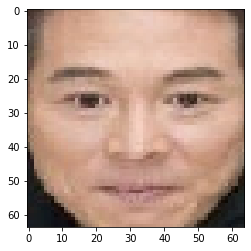

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


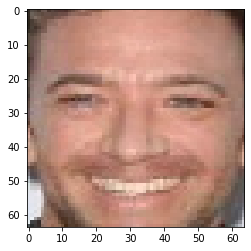

True Label male - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


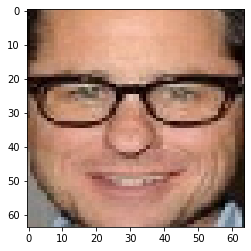

In [83]:
paths = glob.glob(val_dir_male +'/*')

for i in range(0,10):
    test_image = image.load_img(paths[i], target_size = (64, 64))
    plt.imshow(test_image)
    if predicted_class_indices[0][i] == 0:
        pred_label = 'female'
    elif predicted_class_indices[0][i] == 1:
        pred_label = 'male'
    else:
        pred_label = 'stranger'
    
    print('True Label male - Perdict Label : {}'.format(pred_label))
    labels = (test_gen.class_indices)
    print(labels)
    plt.show()

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


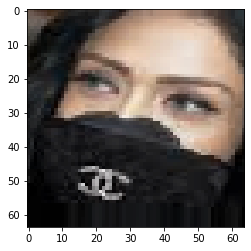

True Label stranger - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


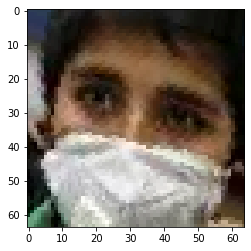

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


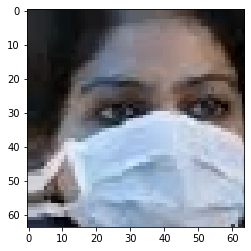

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


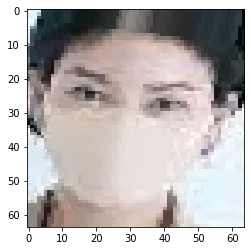

True Label stranger - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


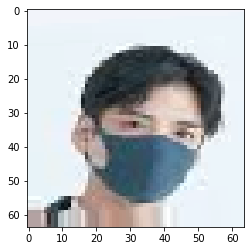

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


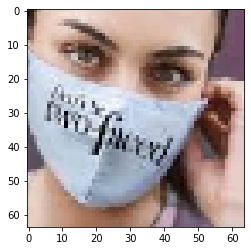

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


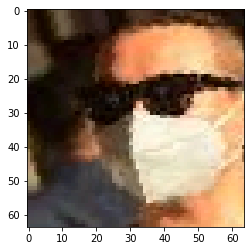

True Label stranger - Perdict Label : male
{'female': 0, 'male': 1, 'stranger': 2}


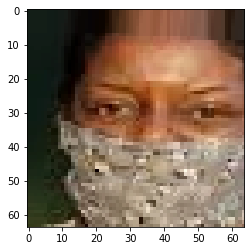

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


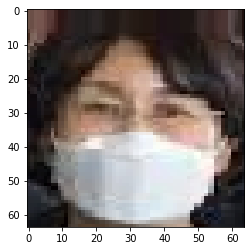

True Label stranger - Perdict Label : female
{'female': 0, 'male': 1, 'stranger': 2}


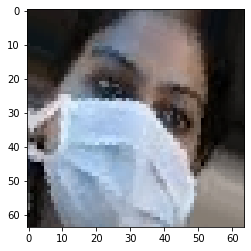

In [84]:
paths = glob.glob(val_dir_stranger +'/*')

for i in range(0,10):
    test_image = image.load_img(paths[i], target_size = (64, 64))
    plt.imshow(test_image)
    if predicted_class_indices[0][i] == 0:
        pred_label = 'female'
    elif predicted_class_indices[0][i] == 1:
        pred_label = 'male'
    else:
        pred_label = 'stranger'
    
    print('True Label stranger - Perdict Label : {}'.format(pred_label))
    labels = (test_gen.class_indices)
    print(labels)
    plt.show()